In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import os
import openslide
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader

In [2]:
#device = torch.device('cuda')
device = torch.device('cpu')

In [ ]:
# load all images
path = '/scratch/cz2064/myjupyter/BDML/Project/metadata/gdc_sample_sheet.2020-03-28.tsv'
metadata = pd.read_csv(path, sep='\t')
imgage_folder = '/scratch/cz2064/myjupyter/BDML/Project/data/'
for i in metadata.index:
    file_id = metadata.loc[i,'File ID']
    file_name = metadata.loc[i,'File Name']
    image_path = imgage_folder + file_id + '/' + file_name
    image = openslide.open_slide(image_path)
    #sample_image = np.array(sample_image.get_thumbnail(sample_image.dimensions))

In [3]:
# load a sample image
imgage_path = '/scratch/cz2064/myjupyter/BDML/Project/data/e9760244-3db6-48e1-aa57-f2e2b5352934/\
TCGA-18-3419-01A-01-BS1.258a5fb6-f212-4a6a-a43a-75541f043038.svs'
image = openslide.open_slide(imgage_path)
print(image.level_count)
print(image.dimensions)
print(image.level_dimensions[1])
print(image.level_dimensions[2])

3
(12000, 17578)
(3000, 4394)
(1500, 2197)


In [4]:
# different sample has different size
imgage_path = '/scratch/cz2064/myjupyter/BDML/Project/data/c9b69594-7be5-4597-8698-7c2880b14b24/\
TCGA-56-8305-11A-01-TS1.dc4b057e-a254-4147-84ce-4542c61d81ce.svs'
image2 = openslide.open_slide(imgage_path)
print(image2.level_count)
print(image2.dimensions)
print(image2.level_dimensions[1])
print(image2.level_dimensions[2])

3
(19920, 28393)
(4980, 7098)
(1245, 1774)


In [4]:
# RGBA image
image_array = np.array(image.read_region((0, 0), 0, image.dimensions))
image_array.shape

(17578, 12000, 4)

In [7]:
#RGB image
image_array = np.array(image.get_thumbnail(image.dimensions))
image_array.shape

(17578, 12000, 3)

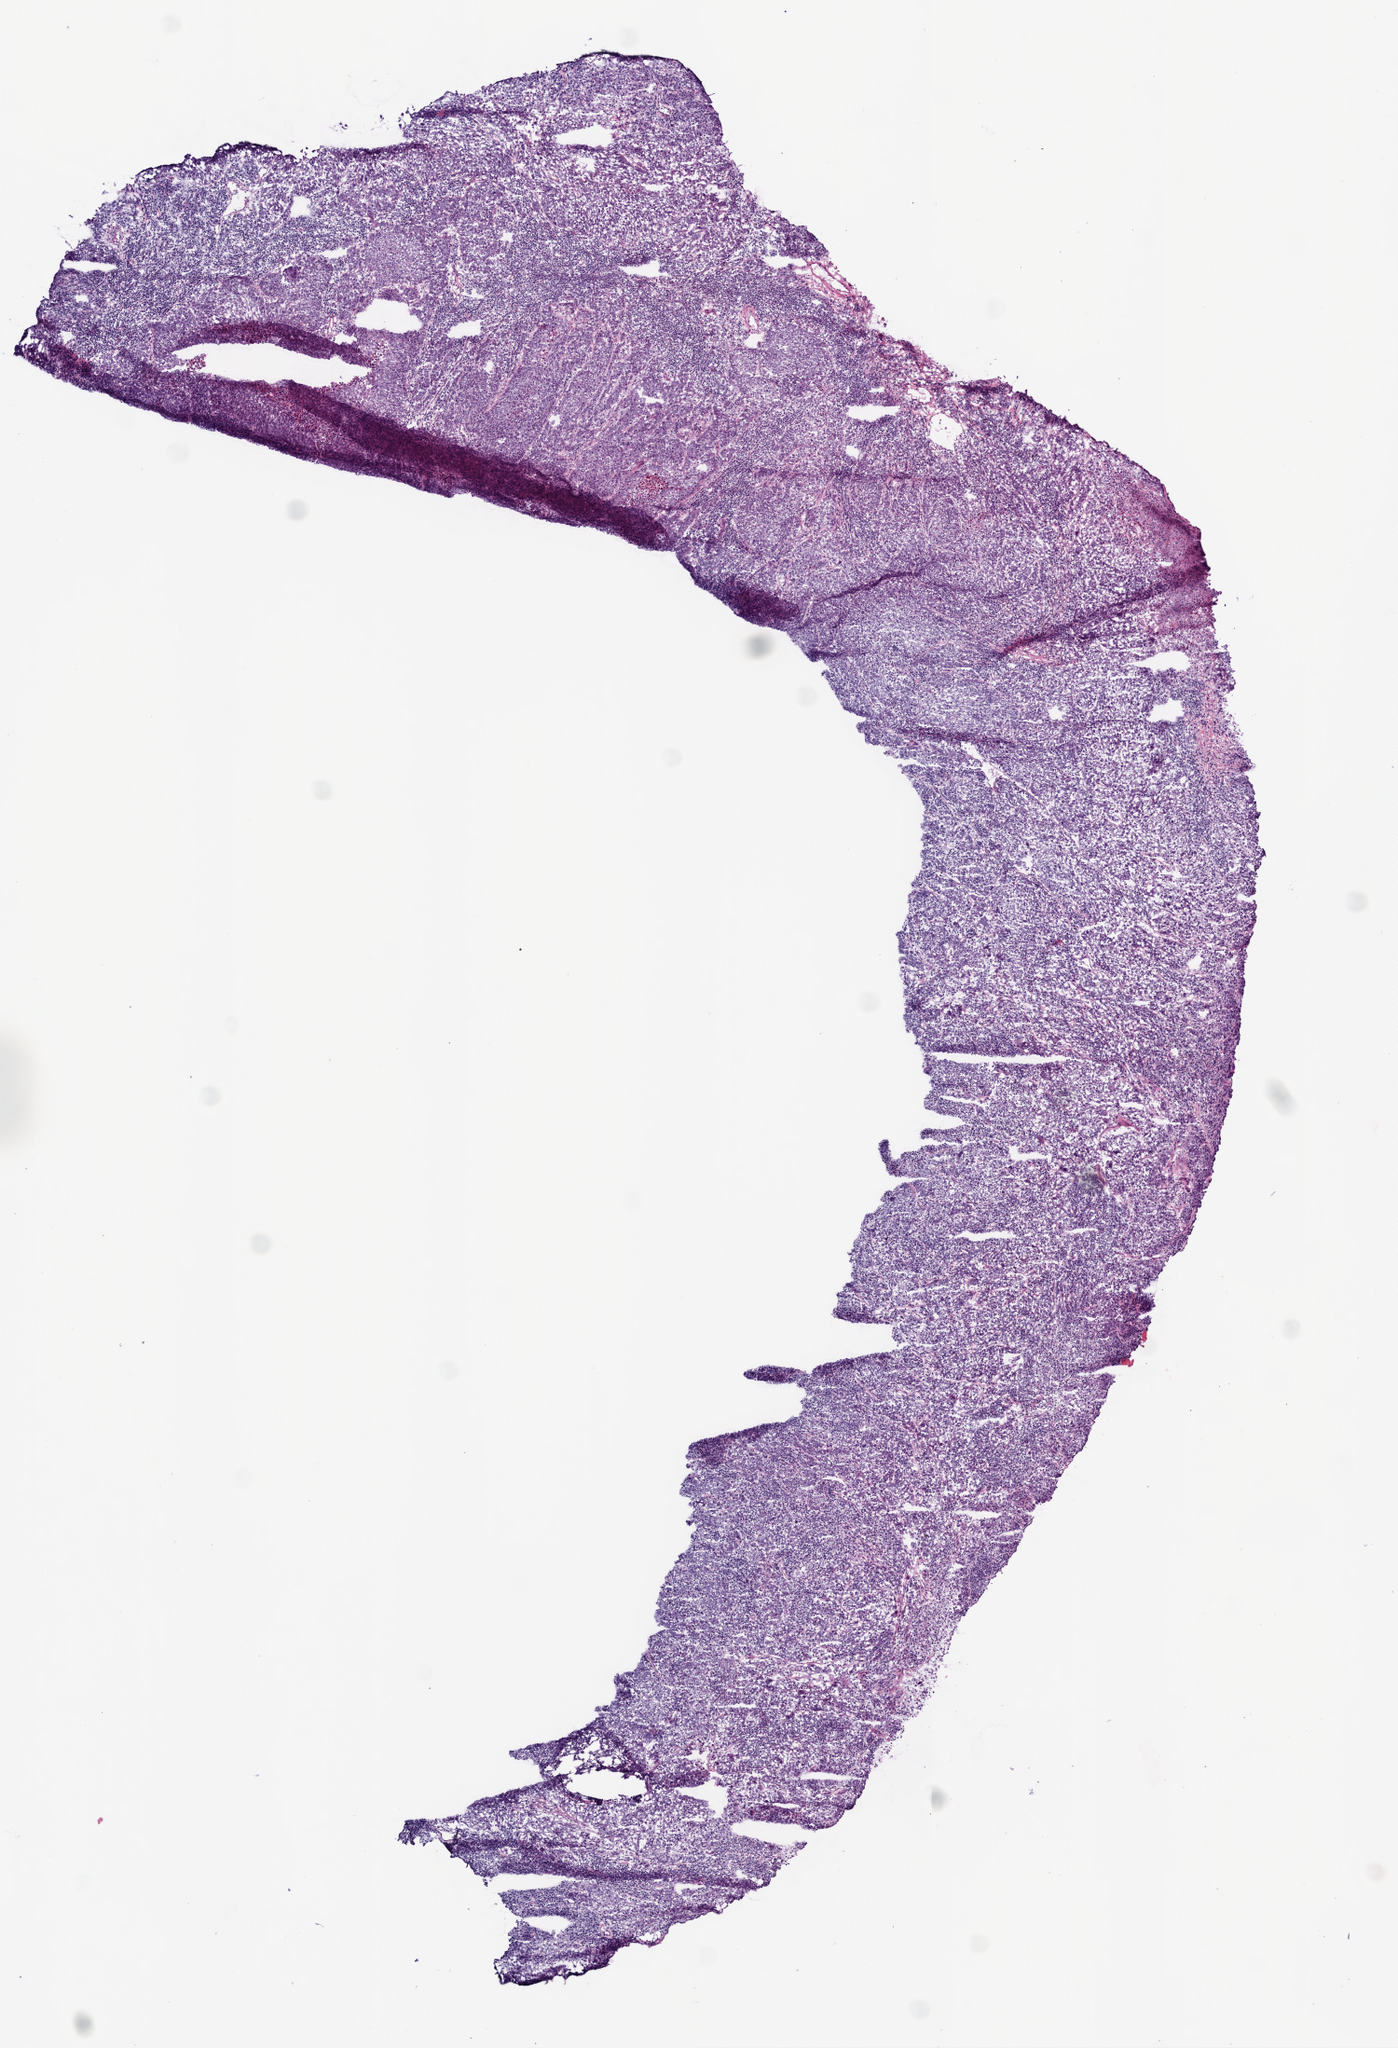

In [13]:
#image.get_thumbnail((image.dimensions[0]/10,image.dimensions[1]/10))
image.get_thumbnail((2048,2048))

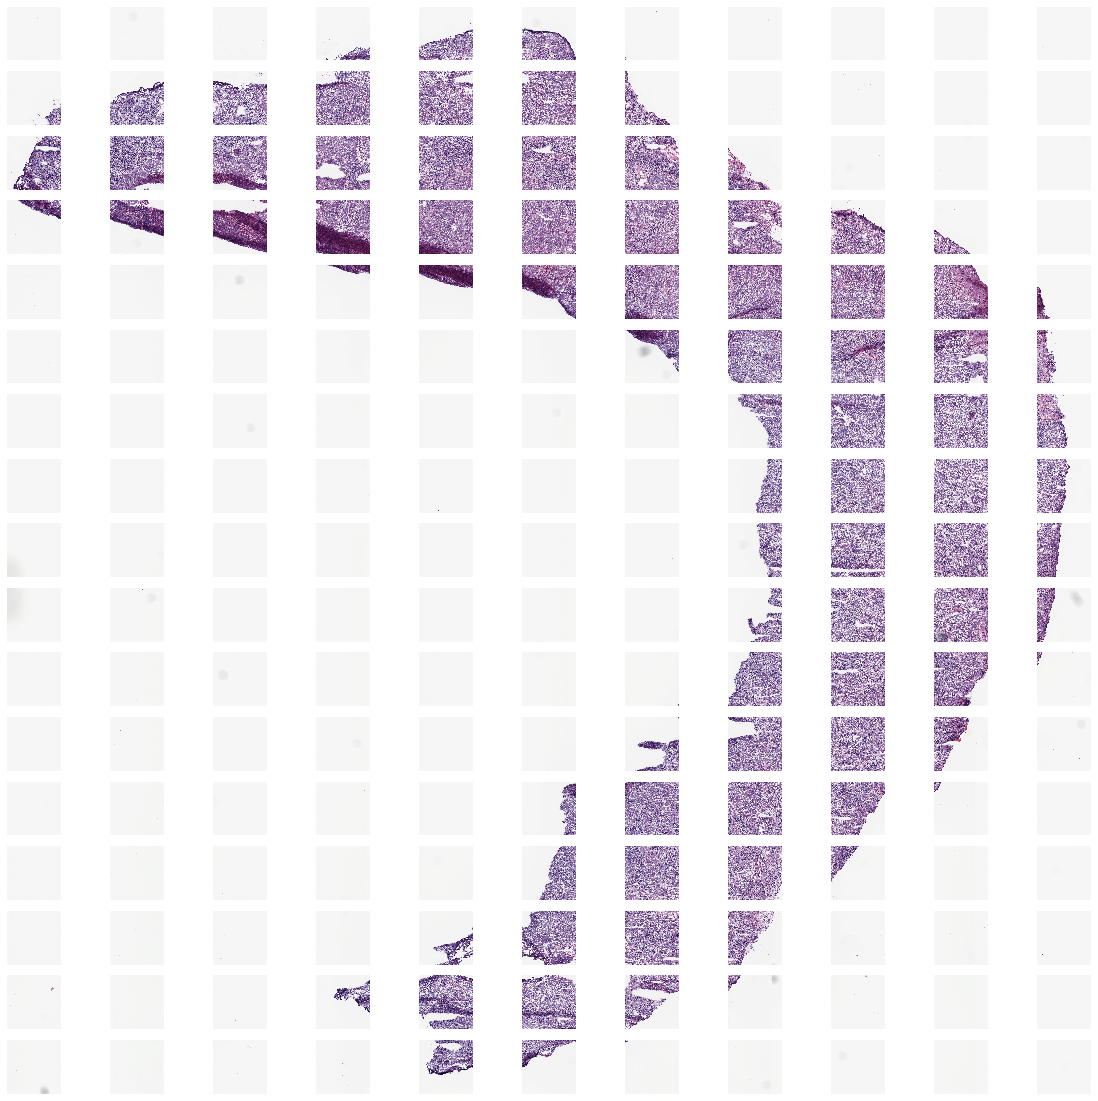

In [8]:
image_dimensions = image_array.shape[:2]
pixels = 1024
fig, axes = plt.subplots(nrows=int(image_dimensions[0]/pixels), ncols=int(image_dimensions[1]/pixels), figsize=(20,20))
for i in range(int(image_dimensions[0]/pixels)):
    for j in range(int(image_dimensions[1]/pixels)):
        sub_image_array = image_array[i*pixels:(i+1)*pixels,j*pixels:(j+1)*pixels,:]
        axes[i, j].imshow(sub_image_array)
        axes[i, j].axis('off')


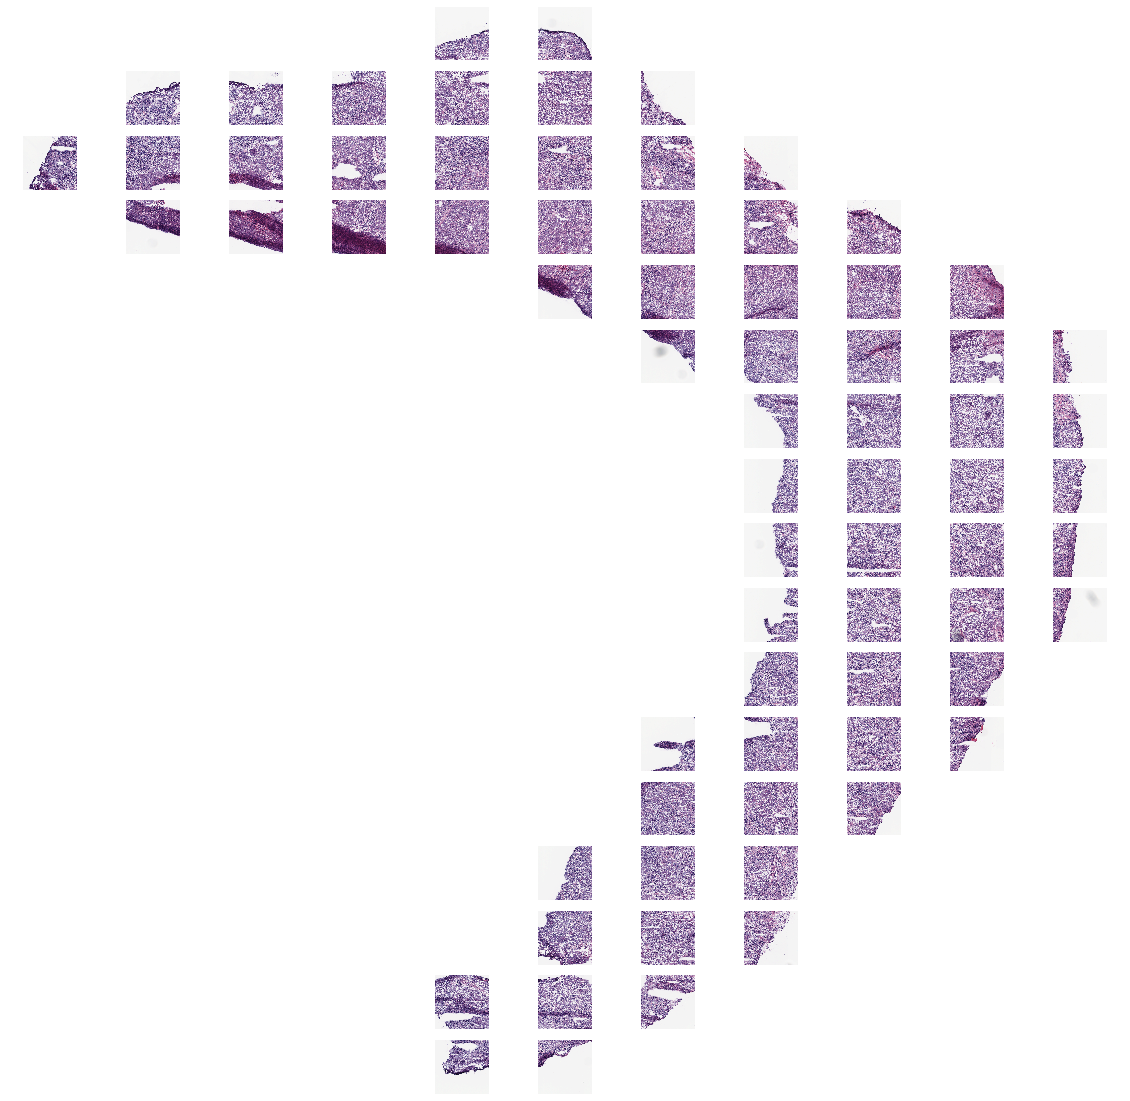

In [9]:
def white_ratio(image):
    width = image.shape[0]
    height = image.shape[1]
    image_reshape = image.reshape(width*height,image.shape[2])
    image_reshape_unique = np.unique(image_reshape,axis=0)
    return len(image_reshape_unique)/len(image_reshape)

image_dimensions = image.dimensions
pixels = 1024
fig, axes = plt.subplots(nrows=int(image_dimensions[1]/pixels), ncols=int(image_dimensions[0]/pixels), figsize=(20,20))
for i in range(int(image_dimensions[1]/pixels)):
    for j in range(int(image_dimensions[0]/pixels)):
        sub_image_array = image_array[i*pixels:(i+1)*pixels,j*pixels:(j+1)*pixels,:]
        if white_ratio(sub_image_array) > 0.1:
            axes[i, j].imshow(sub_image_array)
        axes[i, j].axis('off')

In [ ]:
# creat subsamples
def white_ratio(image):
    width = image.shape[0]
    height = image.shape[1]
    image_reshape = image.reshape(width*height,image.shape[2])
    image_reshape_unique = np.unique(image_reshape,axis=0)
    return len(image_reshape_unique)/len(image_reshape)

imgage_folder = '/scratch/cz2064/myjupyter/BDML/Project/data/'
file_id = 'c9b69594-7be5-4597-8698-7c2880b14b24'
file_name = 'TCGA-56-8305-11A-01-TS1.dc4b057e-a254-4147-84ce-4542c61d81ce.svs'
sample_image = openslide.open_slide(imgage_folder+file_id+'/'+file_name)
sample_image = np.array(sample_image.get_thumbnail(sample_image.dimensions))
image_dimensions = sample_image.shape[:2]
pixels = 1024
valid_subsamples_count = 0
valid_subsamples = []
for i in range(int(image_dimensions[0]/pixels)):
    for j in range(int(image_dimensions[1]/pixels)):
        sub_image_array = sample_image[i*pixels:(i+1)*pixels,j*pixels:(j+1)*pixels,:]
        if white_ratio(sub_image_array) < 0.5:
            subsample_file_name = 'subsample'+ str(valid_subsamples_count)
            save_file = imgage_folder + file_id + '/' + subsample_file_name + '.jpg'
            matplotlib.image.imsave(save_file, sub_image_array)
            valid_subsamples_count = valid_subsamples_count + 1
            valid_subsamples.append(subsample_file_name)
summary_file = imgage_folder + file_id + '/' + 'subsamples_list.txt'
f = open(summary_file,"w")
for i in valid_subsamples:
    i = i + '\n'
    f.write(i)
f.close()